<a href="https://colab.research.google.com/github/mylethidiem/artificial-intelligence-projects/blob/main/Architecture%20Project%20Gradient%20Vanishing%20in%20MLP/1.2_WeightIncreasing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **0. Import libraries**

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch import nn
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import FashionMNIST

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
print(device)

def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)

  torch.cuda.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.benchmark = False
  torch.backends.cudnn.deterministic = True

SEED = 42
set_seed(SEED)

cuda


## **1. Prepare dataset**


In [4]:
train_dataset = FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
test_dataset = FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

100%|██████████| 26.4M/26.4M [00:02<00:00, 9.44MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 167kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.14MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 3.89MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [25]:
train_ratio = 0.9
train_size = int(train_ratio * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print(f"Train size: {train_size}")
print(f"Validation size: {val_size}")
print(f"Test size: {len(test_dataset)}")

Train size: 35429
Validation size: 3937
Test size: 10000


## **2. Build MLP network with `Weight Increasing (std=10.0)`**




In [26]:
class MLP(nn.Module):
  def __init__(self, input_dims, hidden_dims, output_dims):
    super(MLP, self).__init__()
    self.layer1 = nn.Linear(input_dims, hidden_dims)
    self.layer2 = nn.Linear(hidden_dims, hidden_dims)
    self.layer3 = nn.Linear(hidden_dims, hidden_dims)
    self.layer4 = nn.Linear(hidden_dims, hidden_dims)
    self.layer5 = nn.Linear(hidden_dims, hidden_dims)
    self.layer6 = nn.Linear(hidden_dims, hidden_dims)
    self.layer7 = nn.Linear(hidden_dims, hidden_dims)
    self.output = nn.Linear(hidden_dims, output_dims)

    for module in self.modules():
      if isinstance(module, nn.Linear):
        nn.init.normal_(module.weight, mean=0.0, std=10.0)
        nn.init.constant_(module.bias, 0.0)

  def forward(self, x):
    x = nn.Flatten()(x)
    x = self.layer1(x)
    x = nn.Sigmoid()(x)
    x = self.layer2(x)
    x = nn.Sigmoid()(x)
    x = self.layer3(x)
    x = nn.Sigmoid()(x)
    x = self.layer4(x)
    x = nn.Sigmoid()(x)
    x = self.layer5(x)
    x = nn.Sigmoid()(x)
    x = self.layer6(x)
    x = nn.Sigmoid()(x)
    x = self.layer7(x)
    x = nn.Sigmoid()(x)
    output = self.output(x)
    return output

In [27]:
input_dims = 784
hidden_dims = 128
output_dims = 10

model = MLP(input_dims, hidden_dims, output_dims)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
lr = 1e-2
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

## **3. Training**

In [29]:
epochs = 100
train_loss_list = []
val_loss_list = []
train_acc_list = []
val_acc_list = []

for epoch in range(epochs):
  # train
  train_loss = 0.0
  train_acc = 0.0
  num_sample = 0
  model.train()
  for X_train, y_train in train_loader:
    X_train, y_train = X_train.to(device), y_train.to(device)
    optimizer.zero_grad()

    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    train_loss += loss.item()
    train_acc += (torch.argmax(output, dim=1) == y_train).sum().item()
    num_sample += len(y_train)

  train_loss /= len(train_loader)
  train_acc /= num_sample
  train_loss_list.append(train_loss)
  train_acc_list.append(train_acc)

  # validate
  val_loss = 0.0
  val_acc = 0.0
  num_sample = 0
  model.eval()
  with torch.no_grad():
    for X_val, y_val in val_loader:
      X_val, y_val = X_val.to(device), y_val.to(device)

      outputs = model(X_val)
      loss = criterion(outputs, y_val)

      val_loss += loss.item()
      val_acc += (torch.argmax(outputs, dim=1) == y_val).sum().item()
      num_sample += len(y_val)

  val_loss /= len(val_loader)
  val_acc /= num_sample
  val_loss_list.append(val_loss)
  val_acc_list.append(val_acc)
  print(f"EPOCH {epoch+1}/{epochs}: train loss: {train_loss:.4f}, train accuracy: {train_acc:.4f}, validation loss:{val_loss:.4f}, validation accuracy: {val_acc:.4f}")

EPOCH 1/100: train loss: 61.6285, train accuracy: 0.0916, validation loss:60.9649, validation accuracy: 0.0902
EPOCH 2/100: train loss: 55.8116, train accuracy: 0.1007, validation loss:54.3133, validation accuracy: 0.0942
EPOCH 3/100: train loss: 50.7643, train accuracy: 0.1002, validation loss:50.6773, validation accuracy: 0.1128
EPOCH 4/100: train loss: 45.3084, train accuracy: 0.1133, validation loss:49.9456, validation accuracy: 0.1024
EPOCH 5/100: train loss: 43.1953, train accuracy: 0.1036, validation loss:39.9850, validation accuracy: 0.0937
EPOCH 6/100: train loss: 40.3880, train accuracy: 0.1252, validation loss:36.3665, validation accuracy: 0.1171
EPOCH 7/100: train loss: 37.7763, train accuracy: 0.1188, validation loss:36.7480, validation accuracy: 0.1074
EPOCH 8/100: train loss: 40.2405, train accuracy: 0.1252, validation loss:41.1256, validation accuracy: 0.1171
EPOCH 9/100: train loss: 38.7377, train accuracy: 0.1181, validation loss:32.5026, validation accuracy: 0.1476
E

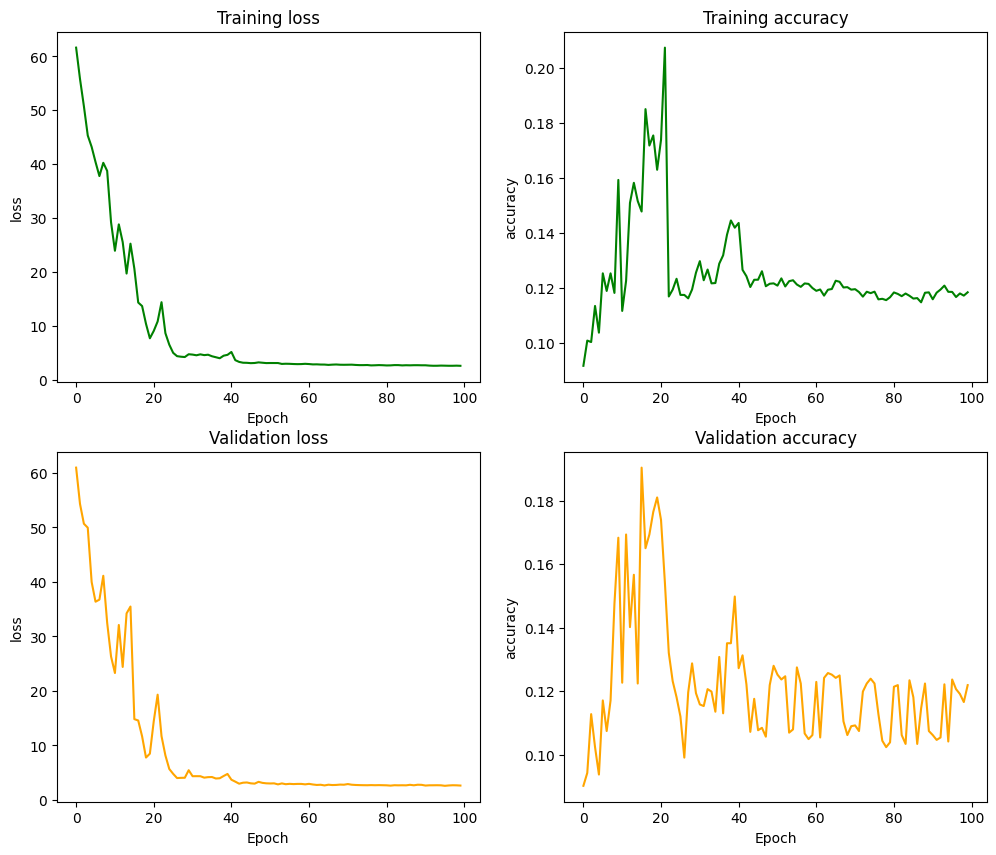

In [33]:
fig, ax = plt.subplots(2,2, figsize=(12,10))

ax[0,0].plot(train_loss_list, color='green')
ax[0,0].set(title='Training loss', xlabel='Epoch', ylabel='loss')

ax[0,1].plot(train_acc_list, color='green')
ax[0,1].set(title='Training accuracy', xlabel='Epoch', ylabel='accuracy')

ax[1,0].plot(val_loss_list, color='orange')
ax[1,0].set(title='Validation loss', xlabel='Epoch', ylabel='loss')

ax[1,1].plot(val_acc_list, color='orange')
ax[1,1].set(title='Validation accuracy', xlabel='Epoch', ylabel='accuracy')
plt.show()

## **4. Evaluation**

In [35]:
test_label = []
test_predict = []

model.eval()
with torch.no_grad():
  for X_test, y_test in test_loader:
    X_test, y_test = X_test.to(device), y_test.to(device)

    output = model(X_test)
    test_label.append(y_test.cpu())
    test_predict.append(output.cpu())
test_label = torch.cat(test_label, dim=0)
test_predict = torch.cat(test_predict, dim=0)

test_acc = (torch.argmax(test_predict, dim=1) == test_label).sum().item() / len(test_label)
print(f"Test accuracy: {test_acc}")

Test accuracy: 0.1182


In [36]:
val_label = []
val_predict = []

model.eval()
with torch.no_grad():
  for X_val, y_val in val_loader:
    X_val, y_val = X_val.to(device), y_val.to(device)

    output = model(X_val)

    val_predict.append(output.cpu())
    val_label.append(y_val.cpu())
  val_predict = torch.cat(val_predict, dim=0)
  val_label = torch.cat(val_label, dim=0)
  val_acc = (torch.argmax(val_predict, dim=1) == val_label).sum().item() / len(val_label)


  print(f'Validation accuracy: {val_acc}')

Validation accuracy: 0.12192024384048768
